# **Sentiment Analysis**

### Install packages

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 199 kB 53.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=027c4653e111db32e5427c9c3c93d77cacdc780c7e4366761e477326425c4060
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


### Import libraries

In [2]:
# pnadas to read data frames
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# for sql queries
from pyspark.sql import SparkSession
from pyspark.sql import Row
import types
from pyspark.sql.types import *
from pyspark import SparkContext 
sc = SparkContext.getOrCreate() 
spark = SparkSession.builder.getOrCreate()

# for NLP
import re #regular expressions
import nltk 
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
import string

# for train test split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Supervised learning algorithms  
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# For algorithm evalution
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read data file
movie_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fellowship.ai/IMDB Dataset.csv')
movie_df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
# remove duplicates
movie_df['dup'] = movie_df.duplicated(subset=None, keep='first')
del movie_df['dup']

### Class Balanced Data

In [6]:
# Applying SQL operations to create data frame
classNameContent = StructType([StructField("review", StringType(), True),
                               StructField("sentiment",  StringType(), True)])
FinalDataSet = spark.createDataFrame(movie_df, classNameContent)
FinalDataSet.createTempView("MovieReviews")

# Check for class balanced nature
print("Total number of Reviews: " + str(FinalDataSet.count()) )
spark.sql(
    "select sentiment, count(sentiment) as count " +
    "from MovieReviews " +
    "group by sentiment "
    "order by sentiment limit 20" ).show()

Total number of Reviews: 50000
+---------+-----+
|sentiment|count|
+---------+-----+
| negative|25000|
| positive|25000|
+---------+-----+



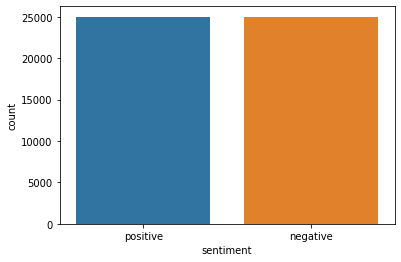

In [7]:
# Visualise class blanace nature
ax = sns.countplot(x="sentiment", data=movie_df)

### Pre Processing

In [8]:
# apply pre processing 

sw = stopwords.words('english') # call stopwords from nltk
lemmatizer = WordNetLemmatizer() # call Lemmatisation from nltk

# get a customised stopwords list
stop_words_file = '/content/drive/MyDrive/Colab Notebooks/Fellowship.ai/SmartStoplist.txt' 
stop_words = []
with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split())      
stop_words = stop_words  

# defining the preprocessing function
def preprocess(text):
    
    text = text.lower() #to convert into lowercase
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags

    text = re.sub(r"br br", "", text)
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw] #removing stopwords
    
    
    text = [lemmatizer.lemmatize(word) for word in text if lemmatizer.lemmatize(word) not in stop_words]
    text = " ".join(text) #Lemmatisation 
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
# Apply preprocessing to review column
movie_df['prep'] = movie_df['review'].apply(lambda x: preprocess(x)) 
del movie_df['review'] # remove review column
movie_df.head(5)

,sentiment,prep
0,positive,one reviewer mentioned watching oz episode hoo...
1,positive,wonderful little production filming technique ...
2,positive,thought wonderful way spend time hot summer we...
3,negative,basically family little boy jake think zombie ...
4,positive,petter mattei love time money visually stunnin...


In [11]:
# observe a sample Review 
sample_corpora = movie_df['prep'].iloc[:1].values
sample_corpora 

array(['one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience 

### Tokenisation

In [12]:
# sql query to store the pre preprosessed data 
FinalDataSet=spark.createDataFrame(movie_df) 
FinalDataSet.printSchema()
FinalDataSet.show(2)

root
 |-- sentiment: string (nullable = true)
 |-- prep: string (nullable = true)

+---------+--------------------+
|sentiment|                prep|
+---------+--------------------+
| positive|one reviewer ment...|
| positive|wonderful little ...|
+---------+--------------------+
only showing top 2 rows



In [13]:
# Convert sentiment into binary values
classes=["negative", "positive"]
classIx=[0,1]
classLookupMap=dict(zip(classes,classIx))

In [14]:
# Tokenize the content and convert the sentiment to a number
# Convert content to array of words
AllTokens_df = FinalDataSet.rdd.map(lambda text: Row(sentiment=classLookupMap[text[0]],prep=re.findall(r"[\w']+" ,text[1].lower())) ).toDF()

AllTokens_df.registerTempTable("allTokens")
AllTokens_df.printSchema()
AllTokens_df.show(2)

root
 |-- sentiment: long (nullable = true)
 |-- prep: array (nullable = true)
 |    |-- element: string (containsNull = true)

+---------+--------------------+
|sentiment|                prep|
+---------+--------------------+
|        1|[one, reviewer, m...|
|        1|[wonderful, littl...|
+---------+--------------------+
only showing top 2 rows



In [15]:
# Split all the text files using non-Word characters 
AllTokensNonWordSplit = FinalDataSet.select('prep').rdd.flatMap(
                        lambda text: re.findall(r"[\w']+", text.prep.lower()) )

print("Number of tokens: " + str(AllTokensNonWordSplit.count()) ) # all tokens
print("Number of distinct tokens: " + str(AllTokensNonWordSplit.distinct().count()) ) # distinct tokens

Number of tokens: 5901011
Number of distinct tokens: 108138


In [16]:
# spread of tokens per review
spark.sql("""
  select min(sz) minimum, avg(sz) average, max(sz) maximum
  from (
    select size(prep) sz
    from allTokens
  )
""").show()

+-------+---------+-------+
|minimum|  average|maximum|
+-------+---------+-------+
|      3|118.02022|   1422|
+-------+---------+-------+



### Word Cloud

In [17]:
# Most common token
tokens = StructType([StructField("token",  StringType(), True)])

# Create a dataframe
AllTokens = spark.createDataFrame(
                   AllTokensNonWordSplit.map(lambda x:[x]), tokens )

AllTokens.registerTempTable("Tokens")

spark.sql("""
    select token, count(token) tokencount 
    from Tokens 
    group by token 
    order by tokencount desc 
    """).toPandas()

,token,tokencount
0,movie,102518
1,film,93033
2,one,55197
3,like,41000
4,time,31250
...,...,...
108133,speaksnot,1
108134,redolence,1
108135,isbetty,1
108136,kirtonyou,1


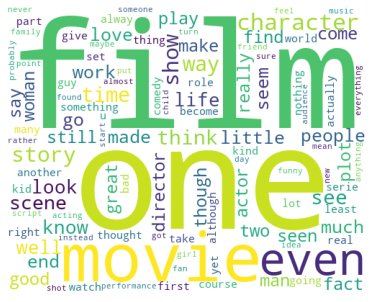

In [18]:
# produce wordclouds
# My Suggestion: we can genrate seperate word clouds for each category 

all_words = '' 

# to extract most common words
for arg in movie_df["prep"]: 

    tokens = arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 500, height = 400, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Train-Test Split

In [19]:
X_train, X_test , y_train, y_test = train_test_split(movie_df['prep'].values,
                                                     movie_df['sentiment'].values,test_size=0.2,
                                                     random_state=42,stratify=movie_df['sentiment'].values)

### TF-IDF Vectorisation

In [20]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

## **Supervised Learning Algorithms** 

### Random Forest Classifier

In [21]:
classifier1 = RandomForestClassifier()
classifier1.fit(tfidf_train_vectors,y_train)

y_pred1 = classifier1.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred1))
print("Accuracy score:", accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      5000
    positive       0.86      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy score: 0.8605


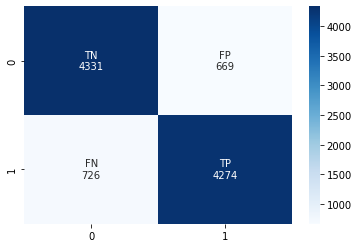

In [22]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred1)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Decision Tree Classifier

In [23]:
classifier2 = DecisionTreeClassifier()
classifier2.fit(tfidf_train_vectors,y_train)

y_pred2 = classifier2.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred2))
print("Accuracy score:", accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      5000
    positive       0.72      0.72      0.72      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

Accuracy score: 0.7216


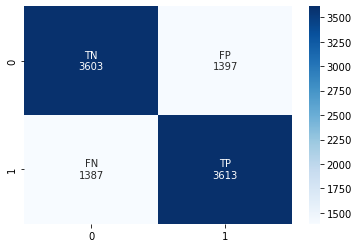

In [24]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred2)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Multinomial Naive Bayes

In [25]:
classifier3 = MultinomialNB()
classifier3.fit(tfidf_train_vectors,y_train)

y_pred3 = classifier3.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred3))
print("Accuracy score:", accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      5000
    positive       0.88      0.85      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy score: 0.8682


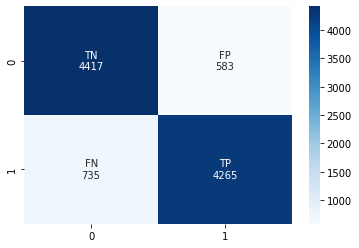

In [26]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred3)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### K Neighbors Classifier

In [27]:
classifier4 = KNeighborsClassifier()
classifier4.fit(tfidf_train_vectors,y_train)

y_pred4 = classifier4.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred4))
print("Accuracy score:", accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

    negative       0.82      0.70      0.75      5000
    positive       0.74      0.84      0.79      5000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Accuracy score: 0.7726


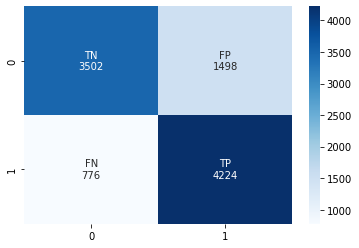

In [28]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred4)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Logistic Regression

In [29]:
classifier5 = LogisticRegression()
classifier5.fit(tfidf_train_vectors,y_train)
y_pred5 = classifier5.predict(tfidf_test_vectors)
print(classification_report(y_test,y_pred5))
print("Accuracy score:", accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy score: 0.8958


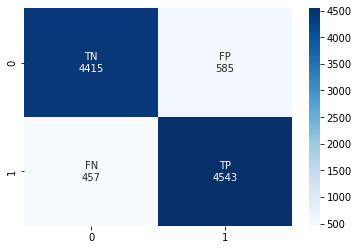

In [30]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred5)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

### Ada Boost Classifier

In [31]:
classifier6 = AdaBoostClassifier()
classifier6.fit(tfidf_train_vectors,y_train)

y_pred6 = classifier6.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred6))
print("Accuracy score:", accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

    negative       0.82      0.78      0.80      5000
    positive       0.79      0.83      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Accuracy score: 0.8028
